In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib
import keras
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
import sys

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

# Check versions
print("Python version:", sys.version)
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("Keras version:", keras.__version__)



Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
OpenCV version: 4.8.0
NumPy version: 1.25.2
Keras version: 2.15.0


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
# make lr and hr images from dataset

"""import cv2
import numpy as np
import os

# Define the base directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/flowers"

# Create directories for HR and LR images if they don't exist
hr_dir = os.path.join(base_dir, "hr_images")
lr_dir = os.path.join(base_dir, "lr_images")

os.makedirs(hr_dir, exist_ok=True)
os.makedirs(lr_dir, exist_ok=True)

# Loop through the original images in the flowers directory
for img_name in os.listdir(base_dir):
    img_path = os.path.join(base_dir, img_name)
    img_array = cv2.imread(img_path)

    if img_array is not None:  # Check if the image is successfully loaded
        # Resize the image for HR
        hr_img = cv2.resize(img_array, (128, 128))
        # Resize the image for LR
        lr_img = cv2.resize(img_array, (32, 32))

        # Save HR and LR images into their respective directories
        hr_img_path = os.path.join(hr_dir, img_name)
        lr_img_path = os.path.join(lr_dir, img_name)

        cv2.imwrite(hr_img_path, hr_img)
        cv2.imwrite(lr_img_path, lr_img)
    else:
        print(f"Failed to load image: {img_path}")
"""

In [ ]:
#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [ ]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [ ]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



In [ ]:
#VGG19
#We need VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer.
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.

In [ ]:
#Load first n number of images (to train on a subset of all images)
n=713
lr_list = os.listdir("/content/drive/MyDrive/Colab Notebooks/flowers/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/Colab Notebooks/flowers/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/drive/MyDrive/Colab Notebooks/flowers/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/Colab Notebooks/flowers/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


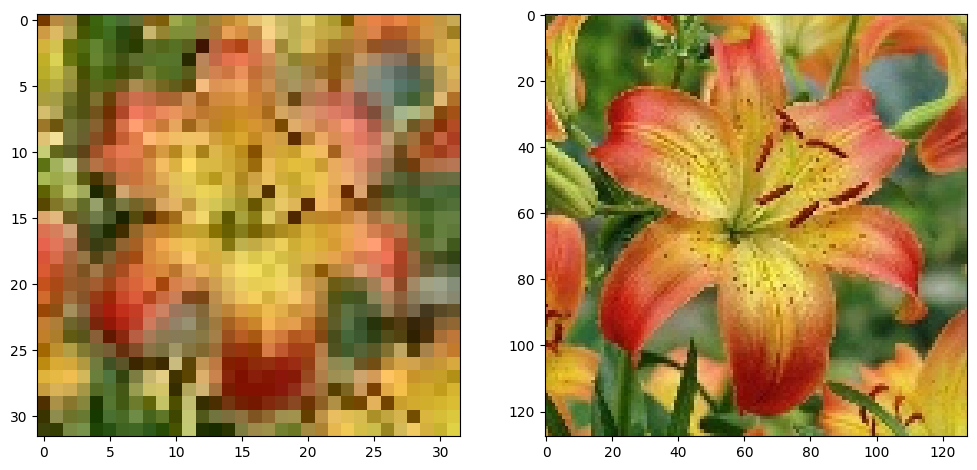

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 20
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.

        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 20 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
       generator.save("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_"+ str(e+1) +".h5")



Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 38ms/step


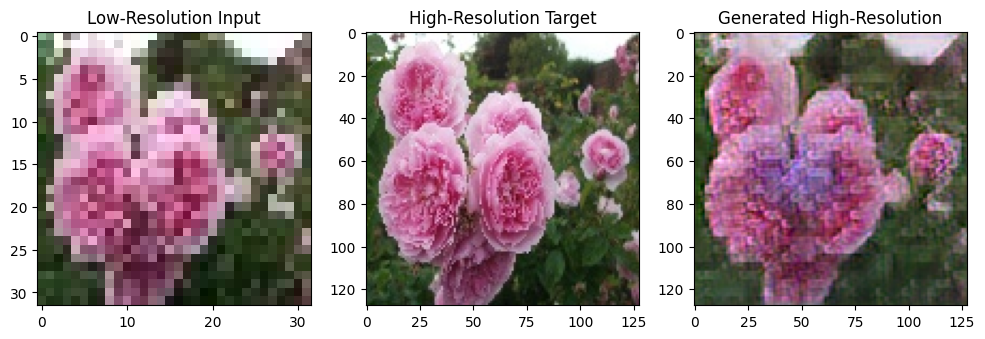

In [ ]:
# Load the generator model
generator_epoch_20 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)

# Select a random example from the test set
image_number = random.randint(0, len(lr_test)-1)
lr_example = lr_test[image_number:image_number+1]
hr_example = hr_test[image_number:image_number+1]

# Generate high-resolution images from the low-resolution input images
generated_hr = generator.predict(lr_example)

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution image
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Low-Resolution Input')
plt.imshow(lr_example[0])
plt.subplot(132)
plt.title('High-Resolution Target')
plt.imshow(hr_example[0])
plt.subplot(133)
plt.title('Generated High-Resolution')
plt.imshow(generated_hr[0])
plt.show()


1/1 [==============================] - 1s 751ms/step


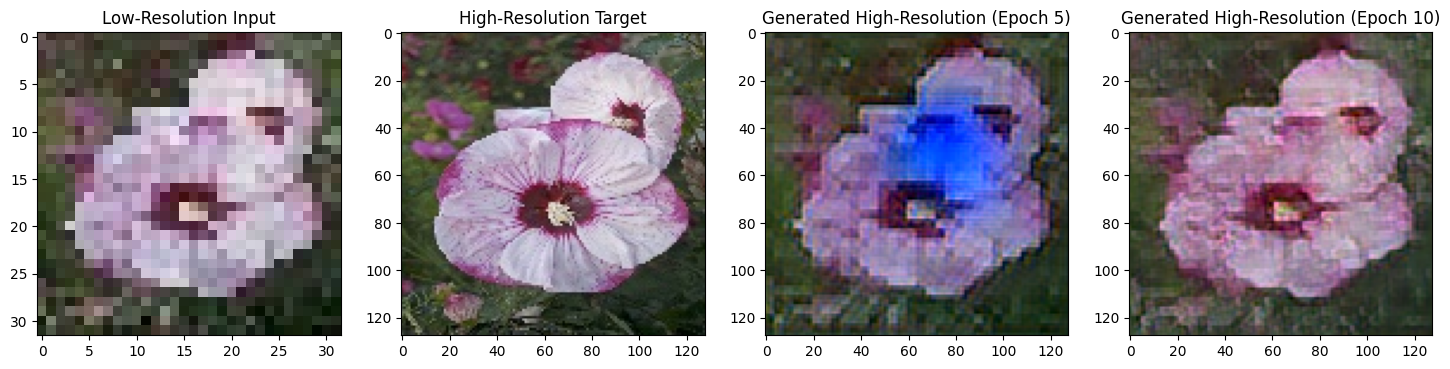

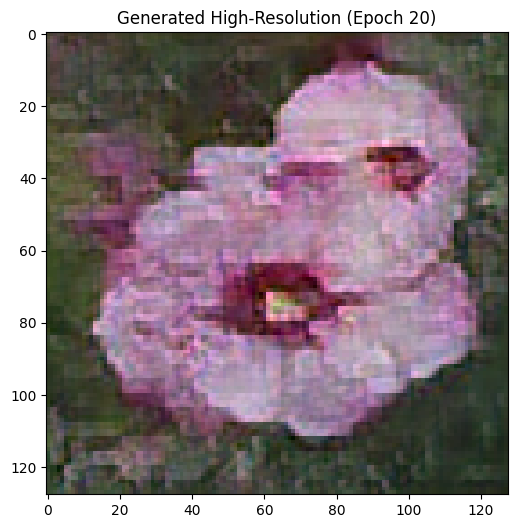

In [ ]:
import matplotlib.pyplot as plt
import random
from keras.models import load_model

# Load the generator models saved after epochs 2, 5, and 10
generator_epoch_2 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_2.h5', compile=False)
generator_epoch_5 = load_model("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_55.h5", compile=False)
generator_epoch_10 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)
generator_epoch_20 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)


# Select a random example from the test set
image_number = random.randint(0, len(lr_test)-1)
lr_example = lr_test[image_number:image_number+1]
hr_example = hr_test[image_number:image_number+1]

# Generate high-resolution images from the low-resolution input images using each generator model
generated_hr_epoch_2 = generator_epoch_2.predict(lr_example)
generated_hr_epoch_5 = generator_epoch_5.predict(lr_example)
generated_hr_epoch_10 = generator_epoch_10.predict(lr_example)
generated_hr_epoch_20 = generator_epoch_20.predict(lr_example)

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution images
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title('Low-Resolution Input')
plt.imshow(lr_example[0])
plt.subplot(142)
plt.title('High-Resolution Target')
plt.imshow(hr_example[0])
plt.subplot(143)
plt.title('Generated High-Resolution (Epoch 5)')
plt.imshow(generated_hr_epoch_5[0])
plt.subplot(144)
plt.title('Generated High-Resolution (Epoch 10)')
plt.imshow(generated_hr_epoch_10[0])
plt.show()

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution image for epoch 10
plt.figure(figsize=(18, 6))
plt.title('Generated High-Resolution (Epoch 20)')
plt.imshow(generated_hr_epoch_20[0])
plt.show()

1/1 [==============================] - 1s 706ms/step


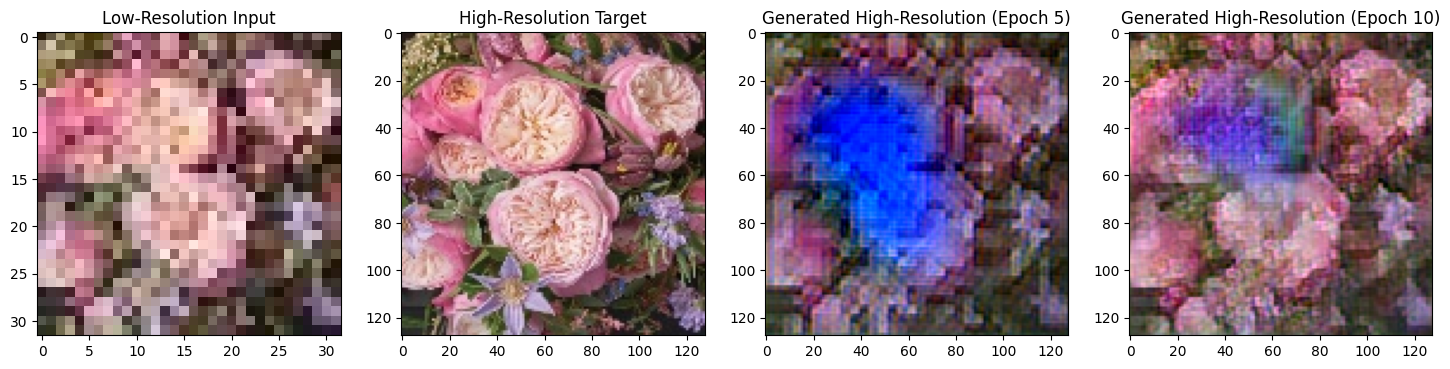

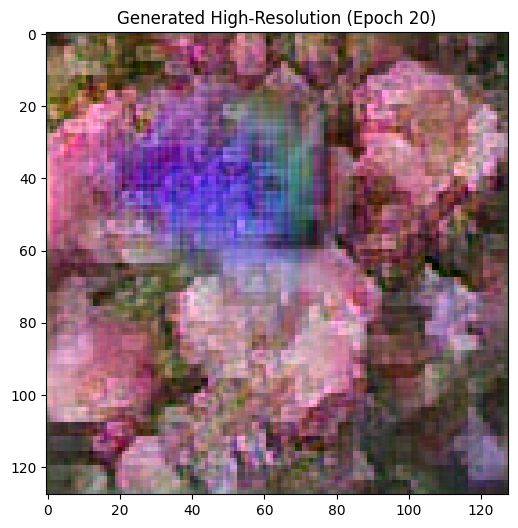

In [ ]:
import matplotlib.pyplot as plt
import random
from keras.models import load_model

# Load the generator models saved after epochs 2, 5, and 10
generator_epoch_2 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_2.h5', compile=False)
generator_epoch_5 = load_model("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_55.h5", compile=False)
generator_epoch_10 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)
generator_epoch_20 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)


# Select a random example from the test set
image_number = random.randint(0, len(lr_test)-1)
lr_example = lr_test[image_number:image_number+1]
hr_example = hr_test[image_number:image_number+1]

# Generate high-resolution images from the low-resolution input images using each generator model
generated_hr_epoch_2 = generator_epoch_2.predict(lr_example)
generated_hr_epoch_5 = generator_epoch_5.predict(lr_example)
generated_hr_epoch_10 = generator_epoch_10.predict(lr_example)
generated_hr_epoch_20 = generator_epoch_20.predict(lr_example)


# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution images
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title('Low-Resolution Input')
plt.imshow(lr_example[0])
plt.subplot(142)
plt.title('High-Resolution Target')
plt.imshow(hr_example[0])
plt.subplot(143)
plt.title('Generated High-Resolution (Epoch 5)')
plt.imshow(generated_hr_epoch_5[0])
plt.subplot(144)
plt.title('Generated High-Resolution (Epoch 10)')
plt.imshow(generated_hr_epoch_10[0])
plt.show()

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution image for epoch 10
plt.figure(figsize=(18, 6))
plt.title('Generated High-Resolution (Epoch 20)')
plt.imshow(generated_hr_epoch_20[0])
plt.show()

1/1 [==============================] - 1s 751ms/step


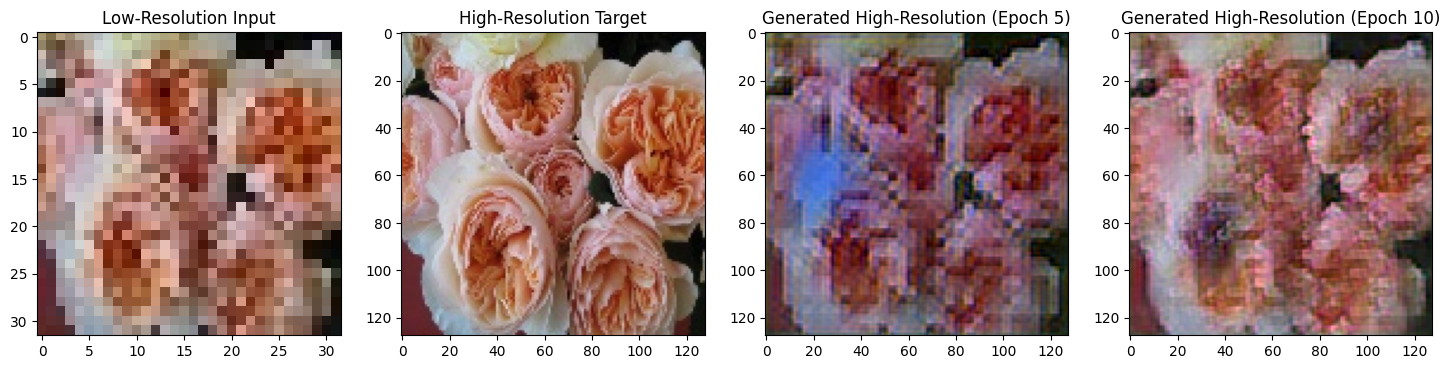

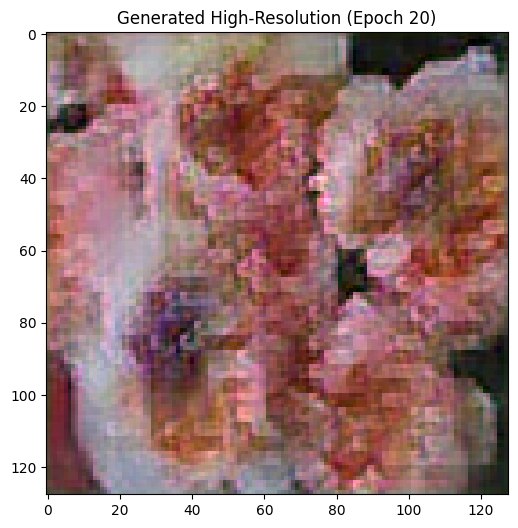

In [ ]:
import matplotlib.pyplot as plt
import random
from keras.models import load_model

# Load the generator models saved after epochs 2, 5, and 10
generator_epoch_2 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_2.h5', compile=False)
generator_epoch_5 = load_model("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_55.h5", compile=False)
generator_epoch_10 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)
generator_epoch_20 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)


# Select a random example from the test set
image_number = random.randint(0, len(lr_test)-1)
lr_example = lr_test[image_number:image_number+1]
hr_example = hr_test[image_number:image_number+1]

# Generate high-resolution images from the low-resolution input images using each generator model
generated_hr_epoch_2 = generator_epoch_2.predict(lr_example)
generated_hr_epoch_5 = generator_epoch_5.predict(lr_example)
generated_hr_epoch_10 = generator_epoch_10.predict(lr_example)
generated_hr_epoch_20 = generator_epoch_20.predict(lr_example)


# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution images
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title('Low-Resolution Input')
plt.imshow(lr_example[0])
plt.subplot(142)
plt.title('High-Resolution Target')
plt.imshow(hr_example[0])
plt.subplot(143)
plt.title('Generated High-Resolution (Epoch 5)')
plt.imshow(generated_hr_epoch_5[0])
plt.subplot(144)
plt.title('Generated High-Resolution (Epoch 10)')
plt.imshow(generated_hr_epoch_10[0])
plt.show()

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution image for epoch 10
plt.figure(figsize=(18, 6))
plt.title('Generated High-Resolution (Epoch 20)')
plt.imshow(generated_hr_epoch_20[0])
plt.show()

1/1 [==============================] - 1s 745ms/step


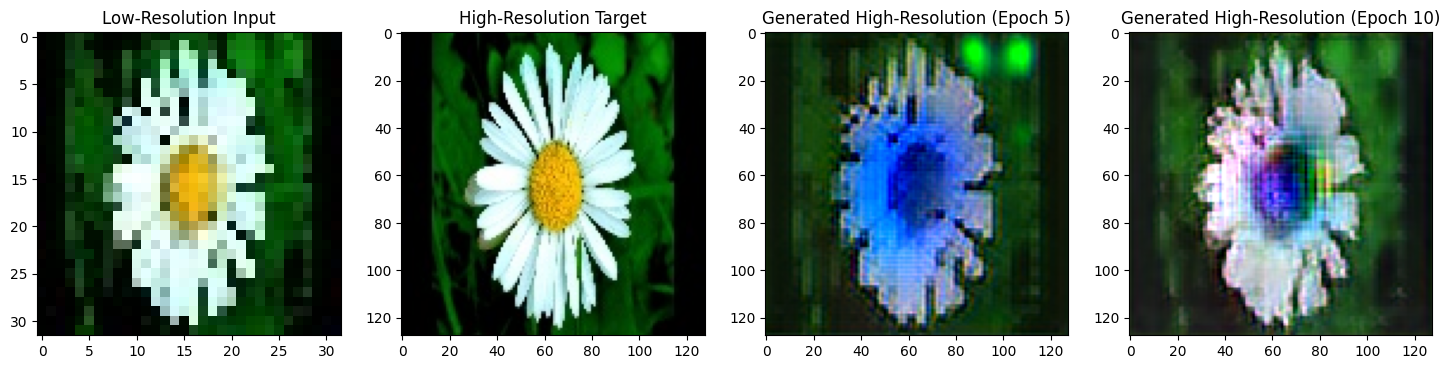

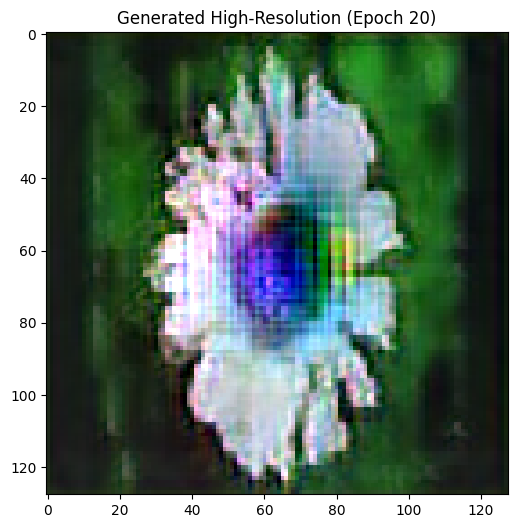

In [ ]:
import matplotlib.pyplot as plt
import random
from keras.models import load_model

# Load the generator models saved after epochs 2, 5, and 10
generator_epoch_2 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_2.h5', compile=False)
generator_epoch_5 = load_model("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_55.h5", compile=False)
generator_epoch_10 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)
generator_epoch_20 = load_model('/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_20.h5', compile=False)


# Select a random example from the test set
image_number = random.randint(0, len(lr_test)-1)
lr_example = lr_test[image_number:image_number+1]
hr_example = hr_test[image_number:image_number+1]

# Generate high-resolution images from the low-resolution input images using each generator model
generated_hr_epoch_2 = generator_epoch_2.predict(lr_example)
generated_hr_epoch_5 = generator_epoch_5.predict(lr_example)
generated_hr_epoch_10 = generator_epoch_10.predict(lr_example)
generated_hr_epoch_20 = generator_epoch_20.predict(lr_example)


# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution images
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title('Low-Resolution Input')
plt.imshow(lr_example[0])
plt.subplot(142)
plt.title('High-Resolution Target')
plt.imshow(hr_example[0])
plt.subplot(143)
plt.title('Generated High-Resolution (Epoch 5)')
plt.imshow(generated_hr_epoch_5[0])
plt.subplot(144)
plt.title('Generated High-Resolution (Epoch 10)')
plt.imshow(generated_hr_epoch_10[0])
plt.show()

# Plot the low-resolution input image, the high-resolution target image, and the generated high-resolution image for epoch 10
plt.figure(figsize=(18, 6))
plt.title('Generated High-Resolution (Epoch 20)')
plt.imshow(generated_hr_epoch_20[0])
plt.show()

NameError: name 'os' is not defined

In [ ]:
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the generator model saved after 5 epochs
generator = load_model("/content/drive/MyDrive/Colab Notebooks/flowers/generated_epoch_55.h5")

# Generate high-resolution images using the generator
gen_hr_images = generator.predict(lr_test)

# Visualize the output
num_samples = 5  # Number of samples to visualize

for i in range(num_samples):
    plt.figure(figsize=(12, 6))

    # Plot LR Image
    plt.subplot(1, 3, 1)
    plt.title('LR Image')
    plt.imshow(lr_test[i])

    # Plot Generated HR Image
    plt.subplot(1, 3, 2)
    plt.title('Generated HR Image')
    plt.imshow(gen_hr_images[i])

    # Plot Ground Truth HR Image
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth HR Image')
    plt.imshow(hr_test[i])

    plt.show()


Output hidden; open in https://colab.research.google.com to view.